In [1]:
import os
import random

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
!pip install omegaconf

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device : ', device)

device :  cuda


In [4]:
data_root = os.path.join(os.getcwd(), 'data')
print('data_root : ', data_root)

data_root :  /content/data


In [5]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]),
])

In [6]:
img_size = 28*28
num_classes = 10

num_epochs = 10
batch_size = 32
lr = 5e-3
workers = 2

In [7]:
mnist_dataset = torchvision.datasets.MNIST(root = data_root,
                                           train = True,
                                           download = True,
                                           transform = transform,
                                           )
test_dataset = torchvision.datasets.MNIST(root = data_root,
                                          train = False,
                                          transform = transform)

In [8]:
# Split function

def dataset_split(dataset, split = [0.9, 0.1], random_train_val_split = False):

    indices = list(range(len(dataset)))
    modes = ['train', 'valid', 'test'][: len(split)]
    sizes = np.array(np.cumsum([0] + list(split)) * len(dataset), dtype=int)

    if random_train_val_split:
        train_and_val_idx = indices[: sizes[2]]
        random.shuffle(train_and_val_idx)
        indices = train_and_val_idx + indices[sizes[2] :]

    datasets = {
        mode: torch.utils.data.Subset(
            dataset, indices[sizes[i] : sizes[i + 1]]
        )
        for i, mode in enumerate(modes)
    }

    return datasets

In [10]:
datasets = dataset_split(mnist_dataset,
                         split = [0.9, 0.1],
                         random_train_val_split = False,
                         )
print('datasets : ', datasets)
train_dataset = datasets['train']
valid_dataset = datasets['valid']
print('length of dataset : ', len(train_dataset), len(valid_dataset))

datasets :  {'train': <torch.utils.data.dataset.Subset object at 0x7faff70fb2d0>, 'valid': <torch.utils.data.dataset.Subset object at 0x7faff70fbdd0>}
length of dataset :  54000 6000


In [11]:
def init_dataloader():
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   num_workers = workers,
                                                   )
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   num_workers = workers,
                                                   )
    return train_dataloader, valid_dataloader
train_dataloader, valid_dataloader = init_dataloader()

Shape of sample batch : image torch.Size([32, 1, 28, 28])	 label torch.Size([32])
first sample label of sample batch : 3


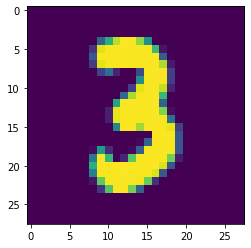

In [12]:
# Check Data Loader
sample_batch = iter(train_dataloader).next()
print(f'Shape of sample batch : image {sample_batch[0].shape}\t label {sample_batch[1].shape}')
print(f'first sample label of sample batch : {sample_batch[1][0]}')
npimg = sample_batch[0][0][0].numpy()
plt.imshow(npimg)

train_dataloader, valid_dataloader = init_dataloader()

In [38]:
from omegaconf import OmegaConf
from omegaconf import DictConfig

# model_configuration
_model_config_dict = {
    'layer_1':{
        'conv2d_in_channels': 1,
        'conv2d_out_channels': 8,
        'conv2d_kernel_size': 3,
        'conv2d_stride': 1,
        'conv2d_padding': 1,
        # batch x 8 x 28 x 28
        'maxpool2d_kernel_size': 2,
        'maxpool2d_stride': 2,
        # batch x 8 x 14 x 14
    },
    'layer_2':{
        'conv2d_in_channels': 8,
        'conv2d_out_channels': 16,
        'conv2d_kernel_size': 3,
        'conv2d_stride': 1,
        'conv2d_padding': 1,
        # batch x 16 x 14 x 14
        'maxpool2d_kernel_size': 2,
        'maxpool2d_stride':2,
        # batch x 16 x 7 x 7
    },
    'fc_1':{
        'in_features': 16*7*7,
        'out_features': 256,
    },
    'fc_2':{
        'in_features': 256,
        'out_features': 64,
    },
    'fc_3':{
        'in_features': 64,
        'out_features': 10,
    },
    'dropout_prob':0.25,
}

_model_config = OmegaConf.create(_model_config_dict)

In [39]:
class CNN(nn.Module):
    def __init__(self, cfg = _model_config):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_1.conv2d_in_channels,
                out_channels=cfg.layer_1.conv2d_out_channels,
                kernel_size=cfg.layer_1.conv2d_kernel_size,
                stride=cfg.layer_1.conv2d_stride,
                padding=cfg.layer_1.conv2d_padding,
            ),
            nn.BatchNorm2d(
                num_features=cfg.layer_1.conv2d_out_channels
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_1.maxpool2d_kernel_size,
                stride=cfg.layer_1.maxpool2d_stride,
            ),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_2.conv2d_in_channels,
                out_channels=cfg.layer_2.conv2d_out_channels,
                kernel_size=cfg.layer_2.conv2d_kernel_size,
                stride=cfg.layer_2.conv2d_stride,
                padding=cfg.layer_2.conv2d_padding,
            ),
            nn.BatchNorm2d(
                num_features=cfg.layer_2.conv2d_out_channels
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_2.maxpool2d_kernel_size,
                stride=cfg.layer_2.maxpool2d_stride,
            ),
        )
        self.fc1 = nn.Linear(
            in_features=cfg.fc_1.in_features,
            out_features=cfg.fc_1.out_features,
        )
        self.fc2 = nn.Linear(
            in_features=cfg.fc_2.in_features,
            out_features=cfg.fc_2.out_features,
        )
        self.fc3 = nn.Linear(
            in_features=cfg.fc_3.in_features,
            out_features=cfg.fc_3.out_features,
        )

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [50]:
model = CNN().to(device)
print(model)

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [52]:
# Early Stopping Callback Object
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        file_name = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f'val_loss-{val_loss}-{file_name}'))
        self.val_loss_min = val_loss

In [53]:
early_stopper = EarlyStopping(
    patience=5, verbose=True, path=os.path.join(os.getcwd(), 'model.ckpt')
)

In [54]:
# Train the model

train_step = 0
log_interval = 500
for epoch in range(1, num_epochs+1):
    # valid step
    with torch.no_grad():
        val_loss = 0.
        model.eval()

        for batch_idx, (val_images, val_labels) in enumerate(
            tqdm(valid_dataloader, position=0, leave=True, desc='valid')
        ):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Forward
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels) / val_outputs.shape[0]

    # valid step logging
    val_epoch_loss = val_loss / len(valid_dataloader)

    print(
        f'{epoch} epoch, {train_step} step: val_epoch_loss: {val_epoch_loss}'
    )

    # early stopping
    early_stopper(val_epoch_loss, model)
    if early_stopper.early_stop:
        break
    
    # train step
    running_loss = 0.
    
    model.train()
    for batch_idx, (images, labels) in enumerate(
        tqdm(train_dataloader, position=0, leave=True, desc='train')
    ):
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Train logging
        if train_step%log_interval == 0:
            train_loss = running_loss / log_interval

            print(
                f'{train_step}: train_loss: {train_loss}'
            )
            running_loss = 0.
        train_step += 1

valid: 100%|██████████| 188/188 [00:01<00:00, 143.68it/s]


1 epoch, 0 step: val_epoch_loss: 0.07276657968759537
Validation loss decreased (inf --> 0.072767).  Saving model ...


train:   0%|          | 2/1688 [00:00<01:25, 19.74it/s]

0: train_loss: 0.004599612712860107


train:  31%|███       | 516/1688 [00:04<00:09, 121.61it/s]

500: train_loss: 0.33366497401101514


train:  61%|██████    | 1022/1688 [00:08<00:05, 116.66it/s]

1000: train_loss: 0.14323826987529173


train:  90%|█████████ | 1521/1688 [00:13<00:01, 115.00it/s]

1500: train_loss: 0.10516914731194266


valid: 100%|██████████| 188/188 [00:01<00:00, 147.16it/s]


2 epoch, 1688 step: val_epoch_loss: 0.00243945000693202
Validation loss decreased (0.072767 --> 0.002439).  Saving model ...


train:  19%|█▉        | 328/1688 [00:02<00:11, 118.43it/s]

2000: train_loss: 0.06340720391750801


train:  50%|████▉     | 836/1688 [00:07<00:07, 116.82it/s]

2500: train_loss: 0.09769911954598501


train:  78%|███████▊  | 1325/1688 [00:11<00:03, 114.35it/s]

3000: train_loss: 0.0950919428259367


valid: 100%|██████████| 188/188 [00:01<00:00, 145.95it/s]


3 epoch, 3376 step: val_epoch_loss: 0.0020708220545202494
Validation loss decreased (0.002439 --> 0.002071).  Saving model ...


train:   8%|▊         | 137/1688 [00:01<00:13, 117.99it/s]

3500: train_loss: 0.023161933121271433


train:  38%|███▊      | 642/1688 [00:05<00:08, 116.55it/s]

4000: train_loss: 0.08535110959020677


train:  68%|██████▊   | 1145/1688 [00:09<00:04, 112.12it/s]

4500: train_loss: 0.08173058680212125


train:  97%|█████████▋| 1645/1688 [00:14<00:00, 114.79it/s]

5000: train_loss: 0.09057084723099251


valid: 100%|██████████| 188/188 [00:01<00:00, 145.05it/s]


4 epoch, 5064 step: val_epoch_loss: 0.0024754235055297613
EarlyStopping counter: 1 out of 5


train:  27%|██▋       | 451/1688 [00:04<00:11, 110.83it/s]

5500: train_loss: 0.06017350077342416


train:  57%|█████▋    | 955/1688 [00:08<00:06, 113.25it/s]

6000: train_loss: 0.07286632070563792


train:  86%|████████▌ | 1449/1688 [00:13<00:02, 112.04it/s]

6500: train_loss: 0.07944485436569085


valid: 100%|██████████| 188/188 [00:01<00:00, 144.80it/s]


5 epoch, 6752 step: val_epoch_loss: 0.001948117627762258
Validation loss decreased (0.002071 --> 0.001948).  Saving model ...


train:  16%|█▌        | 263/1688 [00:02<00:12, 114.82it/s]

7000: train_loss: 0.0324419590786274


train:  46%|████▌     | 771/1688 [00:06<00:07, 117.32it/s]

7500: train_loss: 0.07232391732613905


train:  75%|███████▌  | 1272/1688 [00:11<00:03, 115.42it/s]

8000: train_loss: 0.07949406320397975


valid: 100%|██████████| 188/188 [00:01<00:00, 150.14it/s]


6 epoch, 8440 step: val_epoch_loss: 0.0030828644521534443
EarlyStopping counter: 1 out of 5


train:   5%|▍         | 81/1688 [00:00<00:15, 103.21it/s]

8500: train_loss: 0.00932189338922035


train:  34%|███▍      | 577/1688 [00:05<00:09, 113.28it/s]

9000: train_loss: 0.057320678391362886


train:  64%|██████▎   | 1073/1688 [00:09<00:05, 111.61it/s]

9500: train_loss: 0.0703322743489116


train:  94%|█████████▎| 1579/1688 [00:14<00:00, 110.21it/s]

10000: train_loss: 0.062245931135279535


valid: 100%|██████████| 188/188 [00:01<00:00, 146.06it/s]


7 epoch, 10128 step: val_epoch_loss: 0.002524508163332939
EarlyStopping counter: 2 out of 5


train:  23%|██▎       | 393/1688 [00:03<00:11, 112.68it/s]

10500: train_loss: 0.040402529045954


train:  52%|█████▏    | 884/1688 [00:07<00:07, 107.94it/s]

11000: train_loss: 0.06677298940447508


train:  82%|████████▏ | 1392/1688 [00:12<00:02, 111.98it/s]

11500: train_loss: 0.06519794312561135


valid: 100%|██████████| 188/188 [00:01<00:00, 139.74it/s]


8 epoch, 11816 step: val_epoch_loss: 0.0023927500005811453
EarlyStopping counter: 3 out of 5


train:  12%|█▏        | 200/1688 [00:01<00:12, 117.82it/s]

12000: train_loss: 0.014579539312406268


train:  41%|████      | 695/1688 [00:07<00:15, 63.93it/s]

12500: train_loss: 0.061648678954153185


train:  71%|███████   | 1200/1688 [00:11<00:04, 109.01it/s]

13000: train_loss: 0.07426751214327124


train: 100%|██████████| 1688/1688 [00:16<00:00, 103.44it/s]


13500: train_loss: 0.06540008562353614


valid: 100%|██████████| 188/188 [00:01<00:00, 141.13it/s]


9 epoch, 13504 step: val_epoch_loss: 0.0019181352108716965
Validation loss decreased (0.001948 --> 0.001918).  Saving model ...


train:  30%|███       | 509/1688 [00:05<00:10, 113.21it/s]

14000: train_loss: 0.0523136249344825


train:  60%|██████    | 1014/1688 [00:10<00:05, 112.73it/s]

14500: train_loss: 0.05657430402586397


train:  90%|████████▉ | 1511/1688 [00:14<00:01, 113.70it/s]

15000: train_loss: 0.05321485453598507


valid: 100%|██████████| 188/188 [00:01<00:00, 139.50it/s]


10 epoch, 15192 step: val_epoch_loss: 0.0026084582787007093
EarlyStopping counter: 1 out of 5


train:  19%|█▉        | 326/1688 [00:02<00:12, 110.92it/s]

15500: train_loss: 0.032485355412531135


train:  49%|████▉     | 823/1688 [00:07<00:07, 112.56it/s]

16000: train_loss: 0.06233316977335835


train:  78%|███████▊  | 1323/1688 [00:11<00:03, 113.76it/s]

16500: train_loss: 0.05703933487543691


train: 100%|██████████| 1688/1688 [00:14<00:00, 112.63it/s]


In [55]:
def softmax(x, axis=0):
    'numpy softmax'
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x-max)
    sum = np.sum(e_x, axis=axis, keepdims=True)
    f_x = e_x/sum
    return f_x

In [56]:
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=workers,
                                              )

test_labels_list = []
test_preds_list = []
test_outputs_list = []

model.eval()
model.cpu()
for i, (test_images, test_labels) in enumerate(
    tqdm(test_dataloader, position=0, leave=True, desc='test')
):
    test_outputs = model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().numpy())
    test_labels_list.extend(test_labels.detach().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f'acc:{np.mean(test_preds_list == test_labels_list)*100}%')

test: 100%|██████████| 313/313 [00:02<00:00, 111.80it/s]

acc:97.83%


In [57]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:, i], pos_label=i)

0.999698872498326

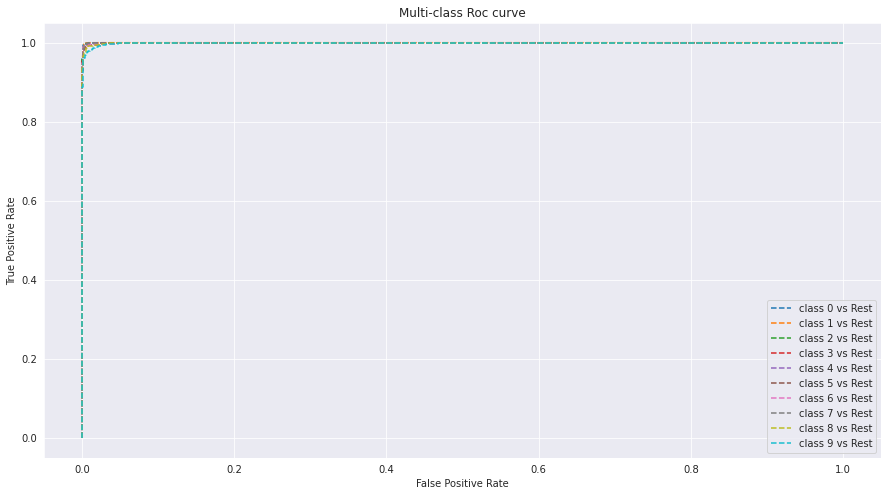

In [58]:
# plot
import seaborn as sns; sns.set_style('darkgrid')
plt.figure(figsize=(15,8))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'class {i} vs Rest')
plt.title('Multi-class Roc curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

roc_auc_score(test_labels_list, test_outputs_list, multi_class='ovo', average='macro')